In [1]:
## Dependencies
from fastai import *
from fastai.vision import *

## We are going to train our model on 6 types of snakes

1. Boa
2. Coral
3. Garter Snake
4. King Cobra
5. King Snake
6. Mamba

In [2]:
classes = ["boa", "coral", "gartersnake",
           "kingcobra", "kingsnake", "mamba"]

## Dowloading the images

In [3]:
for folder in classes:
  folder = folder
  path = Path('data/snakes')
  dest = path/folder
  file = folder+'.txt'
  download_images(path/file, dest, max_pics=200)

## Verifying the images
Sometimes the image we download could be broken, so it is a good practice to verify them first otherwise it will lead to an error.

In [4]:
path = Path('data/snakes')

for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_workers=8)

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [6]:
data.classes

['boa', 'coral', 'gartersnake', 'kingcobra', 'kingsnake', 'mamba']

## Displaying the images

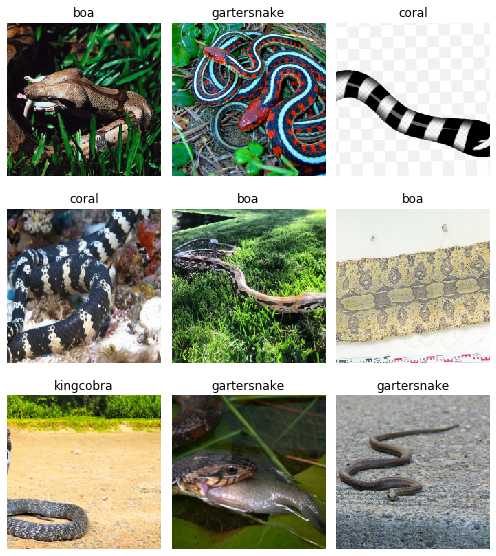

In [7]:
data.show_batch(rows=3, figsize=(7, 8))

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

## Preparing the model

In [9]:
model_34 = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
model_34.fit_one_cycle(4)

In [10]:
model_34.save('error_19%')

Learner(data=ImageDataBunch;

Train: LabelList (882 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
mamba,mamba,mamba,mamba,mamba
Path: data/snakes;

Valid: LabelList (220 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
gartersnake,kingsnake,kingcobra,kingcobra,kingsnake
Path: data/snakes;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

19% doesn't seem bad without fine tuning. let's fine tune it.

In [ ]:
model_34.unfreeze()

In [ ]:
model_34.lr_find()

In [ ]:
model_34.recorder.plot()

We can see that there is sudden slight drop after 1e-4 in the plot and the lowest value is reached at 1e-3, so out optimam values will be in [1e-4, 1e-3]

In [ ]:
model_34.fit_one_cycle(3, max_lr=slice(1e-4, 1e-3))

In [ ]:
model_34.save('error_16%')

In [ ]:
model_34.load('error_16%')

### Interpretations from the model

In [11]:
interpretation_from_model = ClassificationInterpretation.from_learner(model_34)

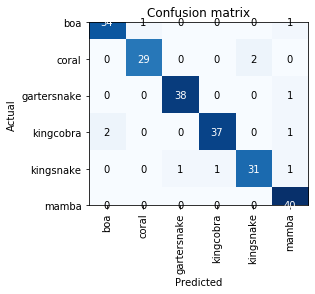

In [12]:
interpretation_from_model.plot_confusion_matrix()

It seems like kingsnake and coral often confuses people, you can see this atricle https://www.wikihow.com/Tell-the-Difference-Between-a-King-Snake-and-a-Coral-Snake. It is common to get confused for even people and we are trying to predict it through an algorithmic model. :)

## Deleting the images which are not relevent to a particular class

In [13]:
from fastai.widgets import *

losses, idxs = interpretation_from_model.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [14]:
ds, idxs = DatasetFormatter().from_toplosses(model_34)

In [15]:
ds

LabelList (882 items)
x: ImageList
Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
y: CategoryList
mamba,mamba,mamba,mamba,mamba
Path: data/snakes

In [17]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

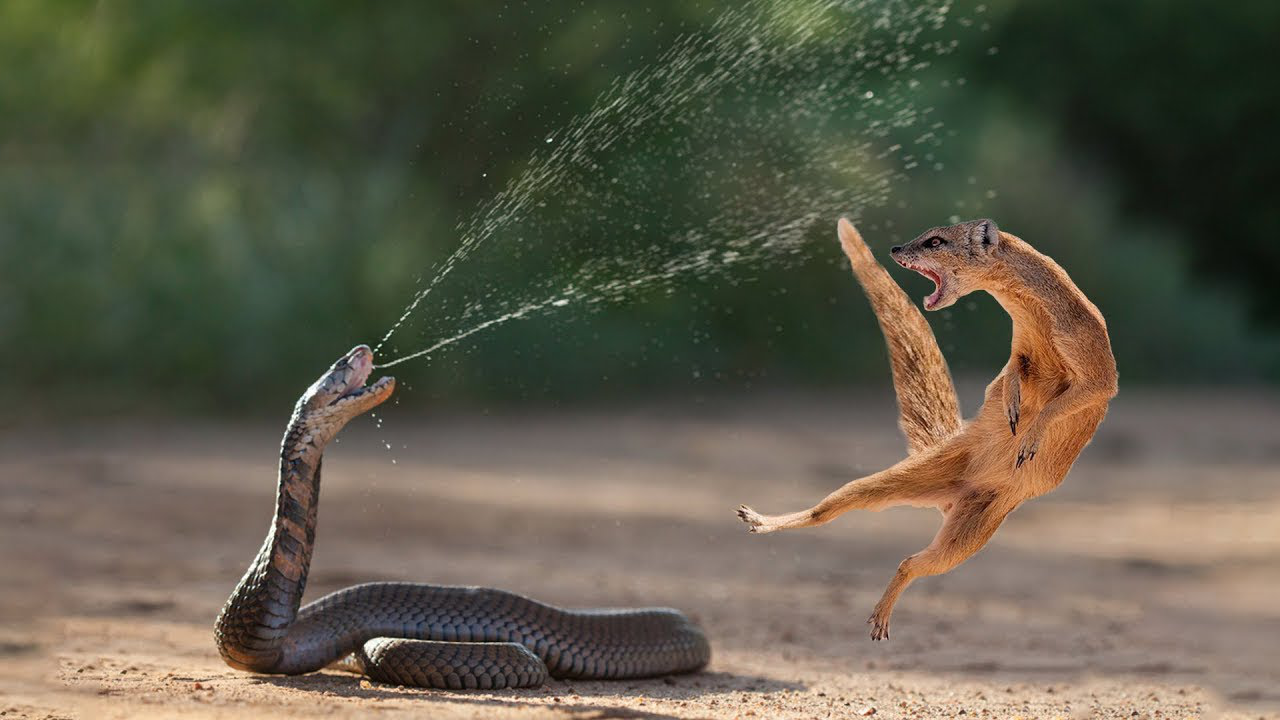

In [18]:
img = open_image(path/'kingcobra'/'00000021.jpg')
img

## making the new data from cleaned data

In [22]:
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [23]:
model_34 = cnn_learner(data2, models.resnet34)
model_34.load('error_16%')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/snakes;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/snakes;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): 

## Let's try to predict now.

In [24]:
pred_class,pred_idx,outputs = model_34.predict(img)
pred_class

Category boa

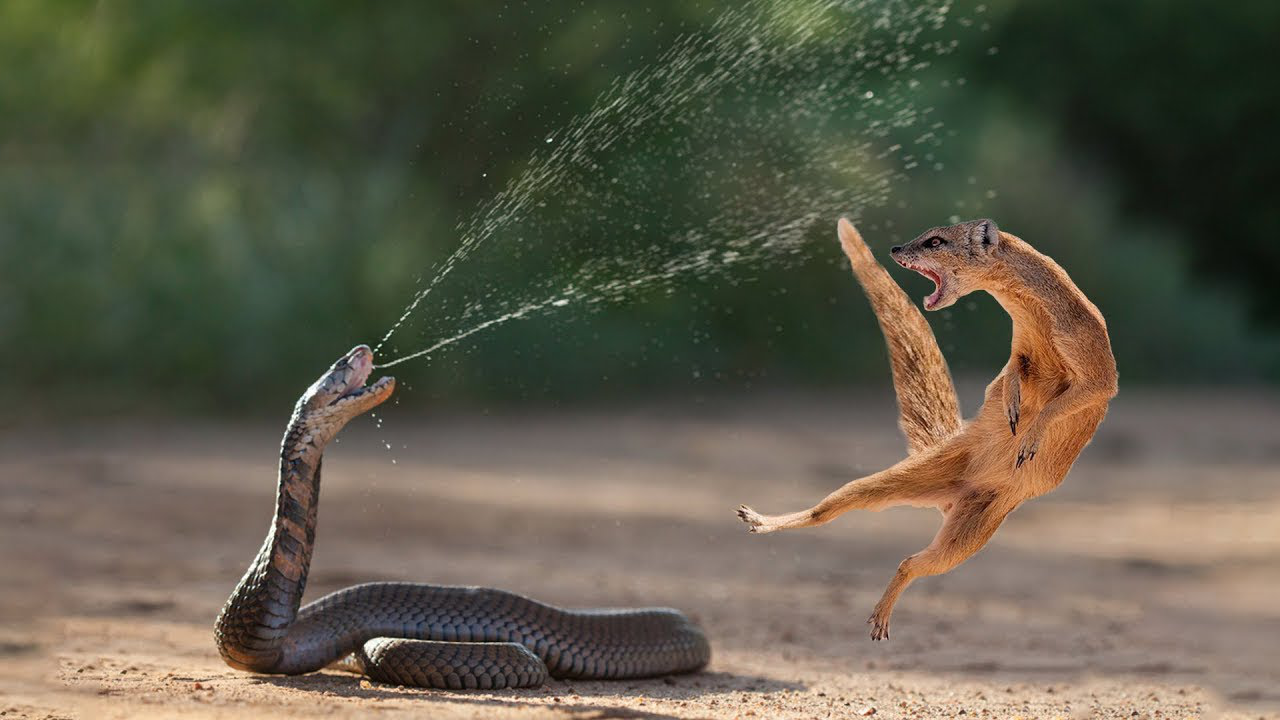

In [25]:
img

In [27]:
img = open_image(path/'kingcobra'/'00000044.jpg')
img

pred_class,pred_idx,outputs = model_34.predict(img)
pred_class

Category kingcobra

In [28]:
img = open_image(path/'boa'/'00000044.jpg')

pred_class,pred_idx,outputs = model_34.predict(img)
pred_class

Category boa

In [29]:
img = open_image(path/'coral'/'00000044.jpg')

pred_class,pred_idx,outputs = model_34.predict(img)
pred_class

Category coral

In [30]:
img = open_image(path/'kingsnake'/'00000044.jpg')

pred_class,pred_idx,outputs = model_34.predict(img)
pred_class

Category kingsnake

Not bad, our images getting predicted 4/5 correctly which is 80% accuracy.

![Snake Hiss](data/snakes/snake.gif "snake")

### That's all. ###